In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from collections import namedtuple

sns.set()

In [2]:
pd.options.display.max_columns = 500

In [3]:
train = pd.read_csv('../data/raw/application_train.csv')
test = pd.read_csv('../data/raw/application_test.csv')
sample_submission = pd.read_csv('../data/raw/sample_submission.csv')

# Домашнее задание №2

*Ниже описание для ДЗ №1*

Ваша задача изучить как различные преобразования влияют на модель и итоговый результат. 

1) Для удобства написать функцию, которая реализовала бы кросс-валидацию. Данная функция принимает на вход данные и другие аргументы на выше усмотрение, на выходе скор на кроссвалидации и его стандартное отклонение.

2) Сделать несколько различных моделей с различными признаками и способами обработки признаков.

    1. Например в первой модели будут использованы  непрерывные признаки   ['metro_km_walk', 'kremlin_km', 'full_sq'] с заполненными пропусками
    
    2. Во второй модели нормируйте признаки из первой модели (std=1, mean = 0). Изменился ли результат? 
    
    3. Во второй модели добавлены преобразованные различным образом категориальне признаки ['product_type' , 'sub_area' ] и т.д.
    
    4. В третьей добавлены datetime признаки 
    
    5. И так далее. Попробуйте реализовать различные гипотезы

3) Для каждой модели нужно сделать кросс-валидацию и засабмитить предсказание на тестовой выборке на кагл

4) Построить график зависимости Leader board score от score на кросс-валидации для всех 5 моделей. 

5) Написать отчет с выводами. 



P.S. Не забудьте про то, что вы можете делать модель для предсказания price_m2, а итоговый результат подсчитывается по price_doc

P.P.S.  Все преобразования, которые вы делаете нужно проделывать и с тестовой выборкой!

P.P.P.S. Можно использовать готовые функции и преобразования из sklearn.

## Функция для кроссвалидации

In [4]:
def cross_validate_score(data, features, target):
    mse_list = []
    msle_list = []
    rmsle_list = []

    kf = KFold(n_splits=5, shuffle=True)

    for i, (train_index, val_index) in enumerate(kf.split(data)):
        train_part = data.loc[train_index, :]
        val_part = data.loc[val_index, :]

        model = LogisticRegression(class_weight = 'balanced')
        model.fit(X=train_part[features], y=train_part[target])
        val_prediction = model.predict(val_part[features])

        mse = mean_squared_error(val_prediction, val_part[target])
        mse_list.append(mse)
        
        msle = mean_squared_log_error(val_prediction, val_part[target])
        msle_list.append(msle)

        rmsle = math.sqrt(msle)
        rmsle_list.append(rmsle)

    Score = namedtuple('Score', ['mse_average', 'rmsle_average', 'msle_average', 'msle_std'])
        
    return Score(np.mean(mse_list), np.mean(rmsle_list), np.mean(msle_list), np.std(msle_list))

## Строим модели и валидируем

### Первая модель
В первой модели будут использованы  непрерывные признаки   [`AMT_CREDIT`, `AMT_ANNUITY`, `AMT_INCOME_TOTAL`] с заполненными пропусками.

In [5]:
features = ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL']
target = 'TARGET'

train_data_1 = train.copy()
train_data_1[features] = train_data_1[features].fillna(0)

test_data_1 = test.copy()
test_data_1[features] = test_data_1[features].fillna(0)

model1 = LogisticRegression(class_weight = 'balanced')
model1.fit(X=train_data_1[features], y=train_data_1[target])

sample_submission[target] = model1.predict(test_data_1[features])

# Save model if needed
# sample_submission.to_csv('predict_1.csv', index=False)

In [6]:
cross_score_1 = cross_validate_score(train_data_1, features, target).rmsle_average
kaggle_score_1 = 0.55585

print('Model 1 (\'AMT_CREDIT\', \'AMT_ANNUITY\', \'AMT_INCOME_TOTAL\')')
print('Cross-validation: {0}\nKaggle: {1}'.format(cross_score_1, kaggle_score_1))

Model 1 ('AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL')
Cross-validation: 0.47336606873490394
Kaggle: 0.55585


### Вторая модель
Во второй модели будут использованы нормированные непрерывные признаки [`AMT_CREDIT`, `AMT_ANNUITY`, `AMT_INCOME_TOTAL`] с заполненными пропусками.

In [7]:
features = ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL']
target = 'TARGET'

mm_scaler = preprocessing.MinMaxScaler() # [0, 1]

train_data_2 = train.copy()
train_data_2[features] = mm_scaler.fit_transform(train_data_2[features].fillna(0))

test_data_2 = test.copy()
test_data_2[features] = mm_scaler.fit_transform(test_data_2[features].fillna(0))

model2 = LogisticRegression(class_weight = 'balanced')
model2.fit(X=train_data_2[features], y=train_data_2[target])

sample_submission[target] = model2.predict(test_data_2[features])

# Save model if needed
# sample_submission.to_csv('predict_2.csv', index=False)

In [8]:
cross_score_2 = cross_validate_score(train_data_2, features, target).rmsle_average
kaggle_score_2 = 0.54383

print('Model 2 (\'AMT_CREDIT\', \'AMT_ANNUITY\', \'AMT_INCOME_TOTAL\')')
print('Cross-validation: {0}\nKaggle: {1}'.format(cross_score_2, kaggle_score_2))

Model 2 ('AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL')
Cross-validation: 0.5220787446227598
Kaggle: 0.54383


### Третья модель
В третьей модели к второй модели добавлены преобразованные категориальный признак `NAME_FAMILY_STATUS`.

In [9]:
features = ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'NAME_FAMILY_STATUS']
target = 'TARGET'

family_status = {
    'Married': 0,
    'Single / not married': 1,
    'Civil marriage': 2,
    'Widow': 3,
    'Separated': 4,
    'Unknown': 5
}

train_data_3 = train_data_2.copy()
train_data_3['NAME_FAMILY_STATUS'] = train_data_3['NAME_FAMILY_STATUS'].replace(family_status)

test_data_3 = test_data_2.copy()
test_data_3['NAME_FAMILY_STATUS'] = test_data_3['NAME_FAMILY_STATUS'].replace(family_status)

model3 = LogisticRegression(class_weight = 'balanced')
model3.fit(X=train_data_3[features], y=train_data_3[target])

sample_submission[target] = model3.predict(test_data_3[features])

# Save model if needed
# sample_submission.to_csv('predict_3.csv', index=False)

In [10]:
cross_score_3 = cross_validate_score(train_data_3, features, target).rmsle_average
kaggle_score_3 = 0.54506

print('Model 3 (\'AMT_CREDIT\', \'AMT_ANNUITY\', \'AMT_INCOME_TOTAL\', \'NAME_FAMILY_STATUS\'')
print('Cross-validation: {0}\nKaggle: {1}'.format(cross_score_3, kaggle_score_3))

Model 3 ('AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'NAME_FAMILY_STATUS'
Cross-validation: 0.5197368950230573
Kaggle: 0.54506


### Четвёртая модель
В чётвертой модели к третьей модели добавлен признак `CODE_GENDER`.

In [11]:
features = ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'NAME_FAMILY_STATUS', 'CODE_GENDER']
target = 'TARGET'

gender = {
    'M': 0,
    'F': 1,
    'XNA': 2
}

train_data_4 = train_data_3.copy()
train_data_4['CODE_GENDER'] = train_data_4['CODE_GENDER'].replace(gender)

test_data_4 = test_data_3.copy()
test_data_4['CODE_GENDER'] = test_data_4['CODE_GENDER'].replace(gender)

model4 = LogisticRegression(class_weight = 'balanced')
model4.fit(X=train_data_4[features], y=train_data_4[target])

sample_submission[target] = model4.predict(test_data_4[features])

# Save model if needed
# sample_submission.to_csv('predict_4.csv', index=False)

In [12]:
cross_score_4 = cross_validate_score(train_data_4, features, target).rmsle_average
kaggle_score_4 = 0.56463

print('Model 4 (\'AMT_CREDIT\', \'AMT_ANNUITY\', \'AMT_INCOME_TOTAL\', \'NAME_FAMILY_STATUS\', \'CODE_GENDER\'')
print('Cross-validation: {0}\nKaggle: {1}'.format(cross_score_4, kaggle_score_4))

Model 4 ('AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'NAME_FAMILY_STATUS', 'CODE_GENDER'
Cross-validation: 0.4276130287191391
Kaggle: 0.56463


### Пятая модель
В пятой модели к четвертой модели добавлен признак `DAYS_EMPLOYED`.

In [13]:
features = ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'NAME_FAMILY_STATUS', 'CODE_GENDER', 'DAYS_EMPLOYED']
target = 'TARGET'

train_data_5 = train_data_4.copy()
train_data_5['DAYS_EMPLOYED'] = train_data_5['DAYS_EMPLOYED'].fillna(0)

test_data_5 = test_data_4.copy()
test_data_5['DAYS_EMPLOYED'] = test_data_5['DAYS_EMPLOYED'].fillna(0)

model5 = LogisticRegression(class_weight = 'balanced')
model5.fit(X=train_data_5[features], y=train_data_5[target])

sample_submission[target] = model5.predict(test_data_5[features])

# Save model if needed
# sample_submission.to_csv('predict_5.csv', index=False)

In [14]:
cross_score_5 = cross_validate_score(train_data_5, features, target).rmsle_average
kaggle_score_5 = 0.53413

print('Model 5 (\'AMT_CREDIT\', \'AMT_ANNUITY\', \'AMT_INCOME_TOTAL\', \'NAME_FAMILY_STATUS\', \'CODE_GENDER\', \'DAYS_EMPLOYED\'')
print('Cross-validation: {0}\nKaggle: {1}'.format(cross_score_5, kaggle_score_5))

Model 5 ('AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'NAME_FAMILY_STATUS', 'CODE_GENDER', 'DAYS_EMPLOYED'
Cross-validation: 0.6037330979464381
Kaggle: 0.53413


## Сравнение и график

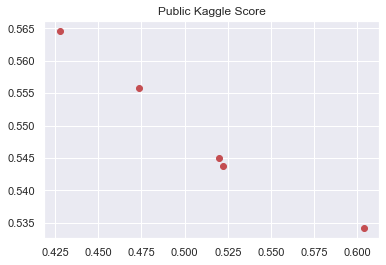

In [15]:
x = [cross_score_1, cross_score_2, cross_score_3, cross_score_4, cross_score_5]
y = [kaggle_score_1, kaggle_score_2, kaggle_score_3, kaggle_score_4, kaggle_score_5]

plt.title('Public Kaggle Score')
plt.plot(x, y, 'ro')
plt.show()